# НИРС

**Студент:** Беспалова Виктория Андреевна

**Группа:** ИУ5-63Б


## Импорт библиотек

In [145]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tabulate import tabulate

%matplotlib inline
sns.set(style="ticks")

## Загрузка и первичный анализ датасета

### Текстовое описание набора данных

| Поле                | Описание                                                                                                         |
|---------------------|------------------------------------------------------------------------------------------------------------------|
| ph                  | pH воды, колеблется от 0 до 14, представляя меру активности водородных ионов в растворе.                           |
| Hardness            | Жесткость воды, выраженная в миллиграммах на литр, способность воды осаждать мыло.                                |
| Solids              | Общее количество растворенных твердых веществ в воде, выраженное в частях на миллион (ppm).                        |
| Chloramines         | Концентрация хлораминов в воде, измеряемая в частях на миллион (ppm).                                              |
| Sulfate             | Концентрация растворенных сульфатов в воде, указанная в миллиграммах на литр.                                      |
| Conductivity        | Электрическая проводимость воды, измеряемая в микросименс на сантиметр (μS/cm).                                    |
| Organic_carbon      | Содержание органического углерода в воде, выраженное в частях на миллион (ppm).                                    |
| Trihalomethanes     | Концентрация тригалометанов в воде, измеренная в микрограммах на литр.                                             |
| Turbidity           | Турбидность воды, измеряемая в нефелометрических единицах турбидности (NTU), показатель степени рассеивания света. |
| Potability          | Показатель пригодности воды для питья: 1 — вода пригодна для потребления, 0 — вода непригодна для питья.           |


### Загрузка датасета

In [146]:
data = pd.read_csv("water_potability.csv")

### Основные характеристики датасета

In [147]:
data.shape

(3276, 10)

In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [149]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [150]:
data['Potability'].unique()

array([0, 1])

Целевой признак является бинарным и содержит только значения 0 и 1.

💡 Решается задача бинарной классификации

## Разведочный анализ данных

In [151]:
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [156]:
data.groupby("Potability").agg(lambda x: x.isna().sum())

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
Potability,,,,,,,,,
0,314,0,0,0,488,0,0,107,0
1,177,0,0,0,293,0,0,55,0


In [152]:
def print_data_description(df):
    sum_table = pd.DataFrame(df.dtypes, columns=['data type'])
    sum_table['missing (%)'] = df.isna().sum() / len(df) * 100
    sum_table['duplicates (%)'] = df.duplicated().sum() / len(df) * 100

    desc = pd.DataFrame(df.describe(include='all').transpose())

    sum_table['min'] = desc['min'].values
    sum_table['max'] = desc['max'].values
    sum_table['mean'] = desc['mean'].values
    sum_table['median'] = desc['50%'].values
    sum_table['std dev'] = desc['std'].values

    numeric_cols = sum_table.columns.drop('data type')
    for col in numeric_cols:
        sum_table[col] = sum_table[col].round(2)

    return sum_table

print_data_description(data)

,data type,missing (%),duplicates (%),min,max,mean,median,std dev
ph,float64,14.99,0.0,0.00,14.00,7.08,7.04,1.59
Hardness,float64,0.00,0.0,47.43,323.12,196.37,196.97,32.88
Solids,float64,0.00,0.0,320.94,61227.20,22014.09,20927.83,8768.57
Chloramines,float64,0.00,0.0,0.35,13.13,7.12,7.13,1.58
Sulfate,float64,23.84,0.0,129.00,481.03,333.78,333.07,41.42
Conductivity,float64,0.00,0.0,181.48,753.34,426.21,421.88,80.82
Organic_carbon,float64,0.00,0.0,2.20,28.30,14.28,14.22,3.31
Trihalomethanes,float64,4.95,0.0,0.74,124.00,66.40,66.62,16.18
Turbidity,float64,0.00,0.0,1.45,6.74,3.97,3.96,0.78
Potability,int64,0.00,0.0,0.00,1.00,0.39,0.00,0.49


💡 Пропуски в данных:

• 15% в колонке ph,  
• 5% в колонке Trihalomethanes,  
• около 25% в колонке Sulfate.

### Баланс классов

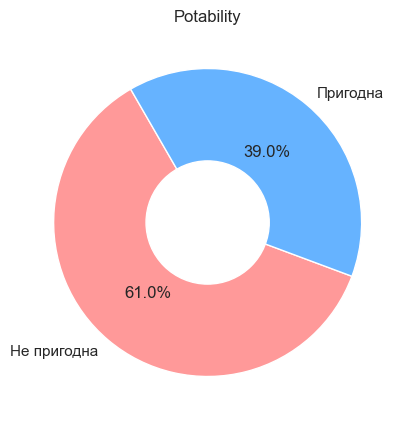

In [153]:
potability_counts = data['Potability'].value_counts()

colors = ['#ff9999','#66b3ff']

plt.figure(figsize=(5, 5))
plt.pie(potability_counts, labels=['Не пригодна', 'Пригодна'], autopct='%1.1f%%', startangle=120, colors=colors)
plt.gca().add_artist(plt.Circle((0, 0), 0.40, color='white'))
plt.title('Potability')
plt.show()


In [154]:
print(data['Potability'].value_counts())

Potability
0    1998
1    1278
Name: count, dtype: int64


💡 Присутствует незначительный дисбаланс классов.  
Дисбаланс действительно ожидаем в данных о качестве воды в реальном мире, поскольку вода в необработанных образцах чаще оказывается не пригодной для питья, чем пригодной.

### Распределение признаков

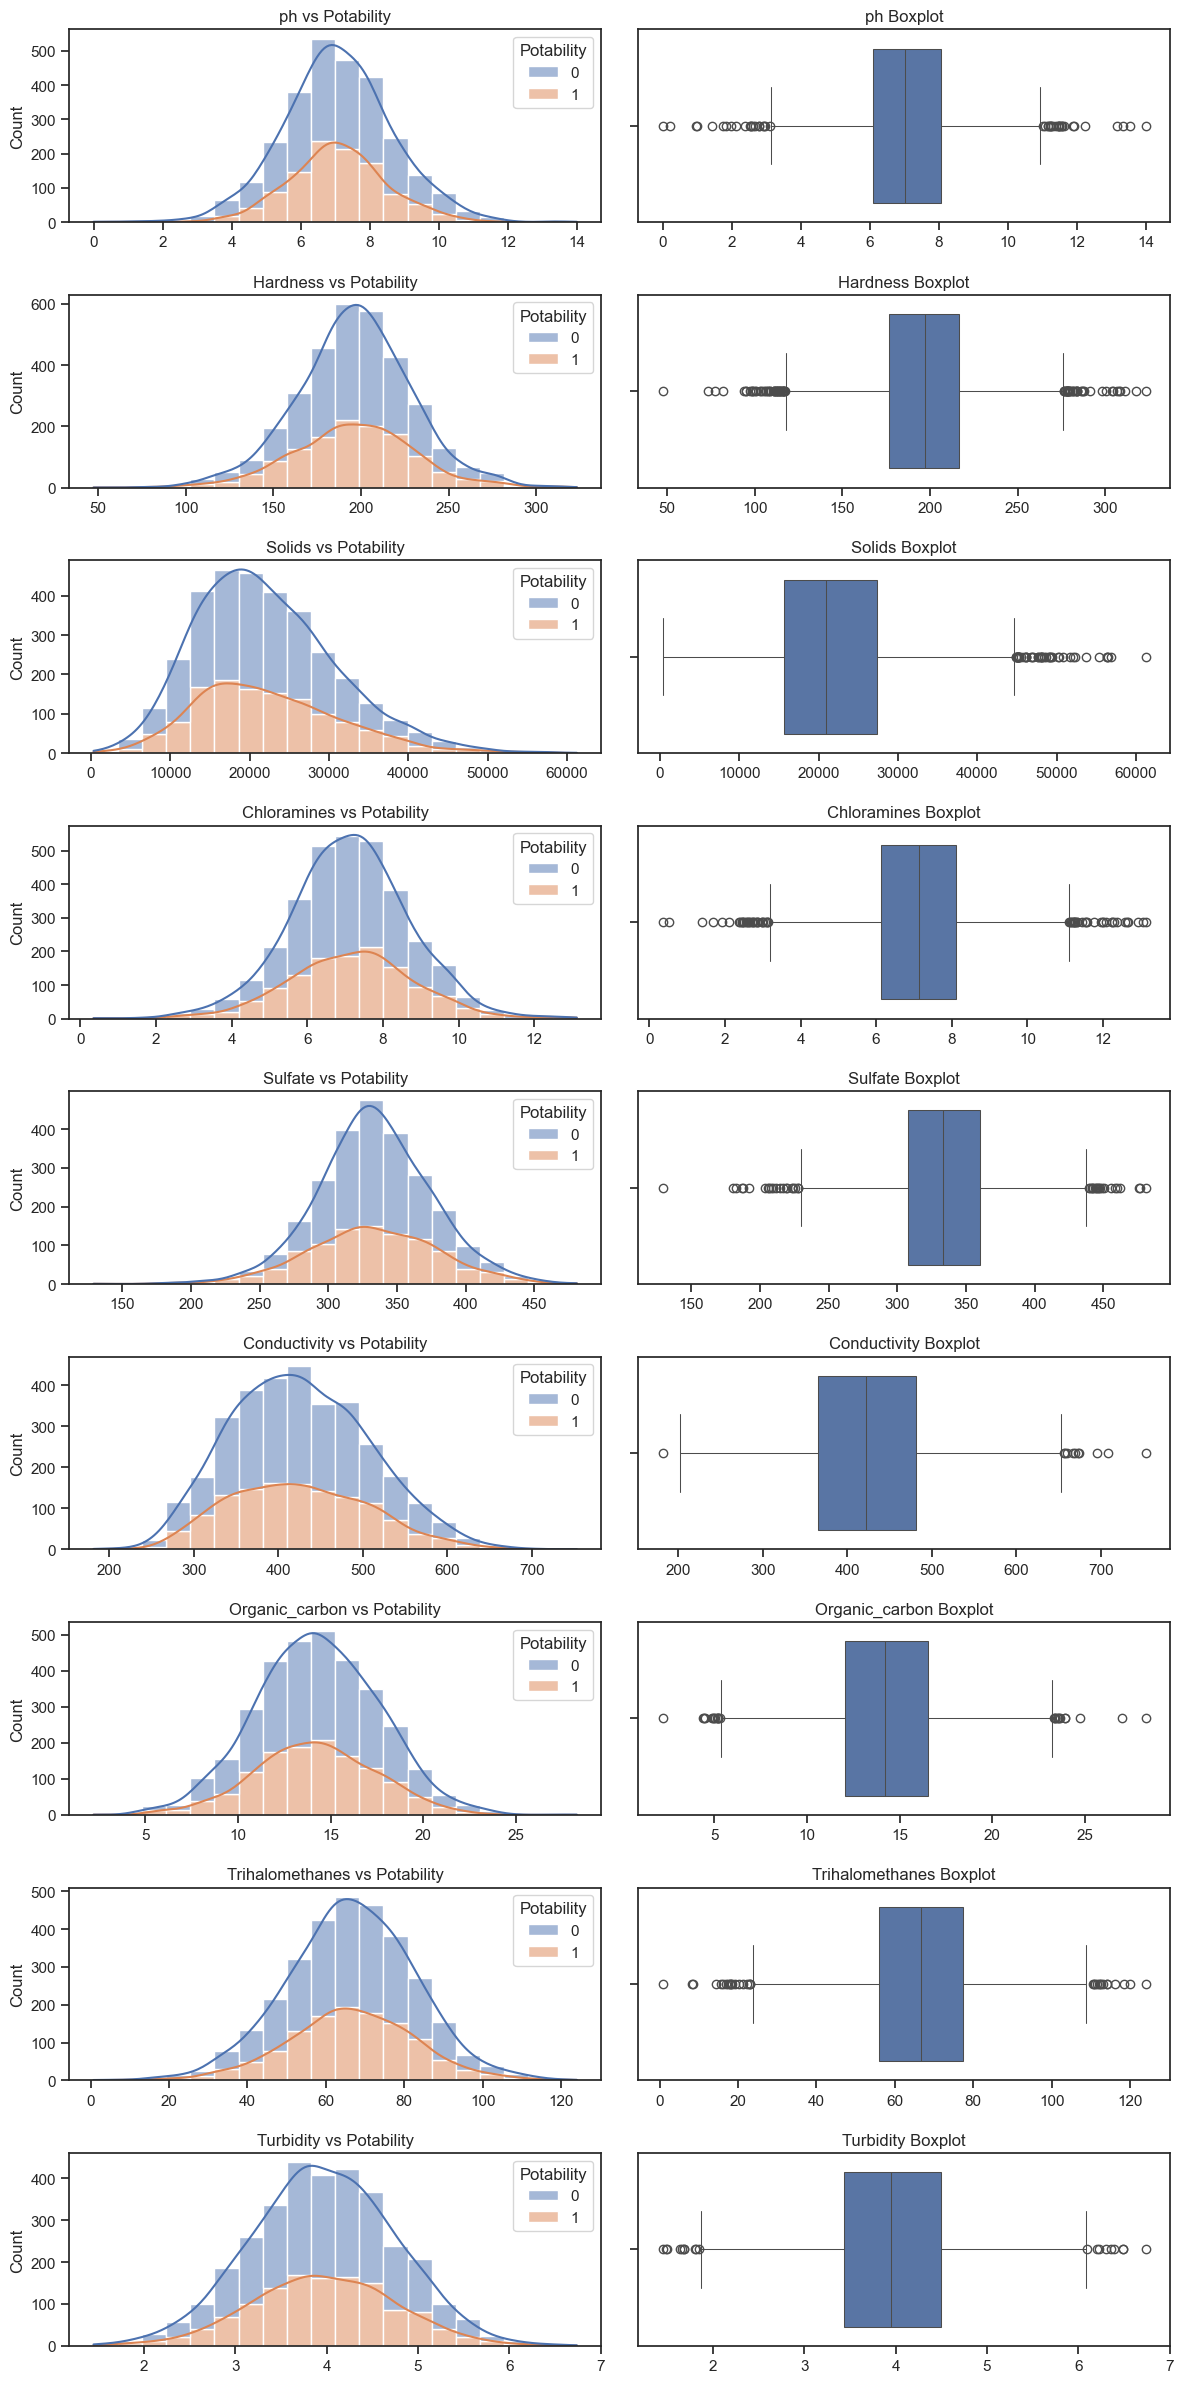

In [155]:
columns = data.columns[:-1]

fig, axes = plt.subplots(len(columns), 2, figsize=(12, 24)) 

for idx, col in enumerate(columns):
    # Гистограмма с разделением по пригодности воды
    sns.histplot(data=data, x=col, hue="Potability", kde=True, color="red", multiple="stack", bins=20, ax=axes[idx, 0])
    axes[idx, 0].set_title(f"{col} vs Potability")
    axes[idx, 0].set_xlabel("")

    # Ящик с усами
    sns.boxplot(data=data, x=col, ax=axes[idx, 1], orient='h', linewidth=.75)
    axes[idx, 1].set_title(f"{col} Boxplot")
    axes[idx, 1].set_xlabel("")

fig.tight_layout(h_pad=1.5, w_pad=1.5)
plt.show()

💡 Распределение признаков:  
• Большинство признаков имеют распределение близкое к нормальному.  
• Показатели такие как Solids и Conductivity демонстрируют положительную асимметрию.
  
💡 Наличие выбросов:  
• Все признаки содержат выбросы.  
• Сохранение выбросов оправдано, т.к. они представляют собой возможные крайние значения измерений качества воды.

💡 Различия в масштабах:  
• Признаки измеряются в значительно разных масштабах --> необходимо масштабирование.

### Заполнение пропусков

In [157]:
result = data.groupby('Potability')[['ph', 'Sulfate', 'Trihalomethanes']].agg(['median', 'mean'])

result.columns = ['_'.join(col).strip() for col in result.columns.values]

table = tabulate(result, headers='keys', tablefmt='pretty')

print(table)

+------------+-------------------+-------------------+--------------------+--------------------+------------------------+----------------------+
| Potability |     ph_median     |      ph_mean      |   Sulfate_median   |    Sulfate_mean    | Trihalomethanes_median | Trihalomethanes_mean |
+------------+-------------------+-------------------+--------------------+--------------------+------------------------+----------------------+
|     0      | 7.03545551588757  | 7.085378435983544 | 333.38942610169323 | 334.56428957868803 |   66.54219804427565    |  66.30355527306088   |
|     1      | 7.036752103833548 | 7.073783295381199 | 331.8381671295742  | 332.56699023366554 |    66.6782137100115    |  66.53968374070116   |
+------------+-------------------+-------------------+--------------------+--------------------+------------------------+----------------------+


Заметим, что медианные и средние значения для колонок, содержащих пропуски, близки.  

Признаки имеют распределение близкое к нормальному, однако есть выбросы.  
Заполним пропуски медианными значениями, так как они менее чувствительны к выбросам.  

In [158]:
median_imputer = SimpleImputer(strategy='median') 

data['ph'] = median_imputer.fit_transform(data[['ph']])
data['Sulfate'] = median_imputer.fit_transform(data[['Sulfate']])
data['Trihalomethanes'] = median_imputer.fit_transform(data[['Trihalomethanes']])

In [159]:
data.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

## Корреляционный анализ данных

<Axes: >

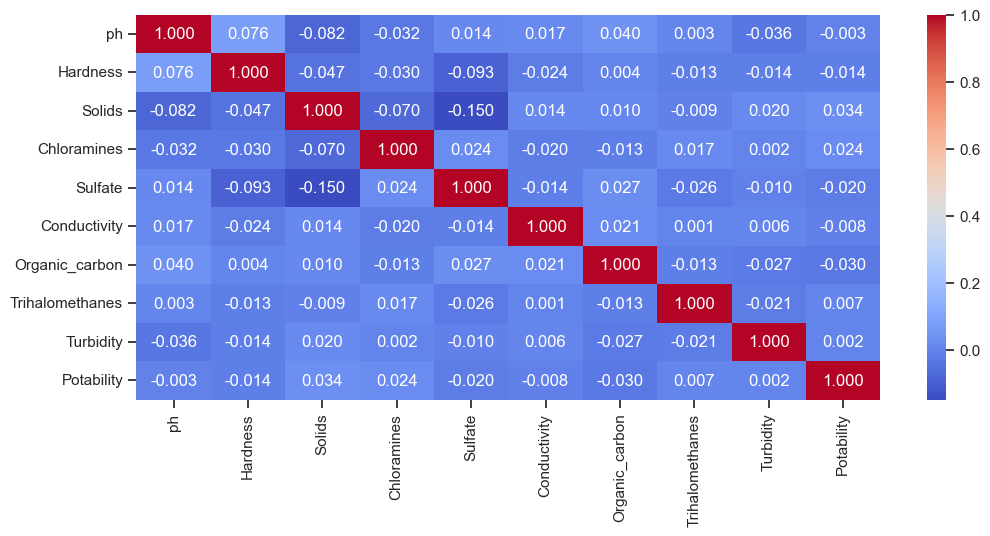

In [160]:
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(data.corr(method='pearson'), ax=ax, annot=True, fmt='.3f',  cmap='coolwarm', cbar=True)

💡 Признаки не имеют корреляции между собой --> нет избыточных признаков.  
💡 Целевой признак не имеет корреляции с остальными признаками.

## Выбор метрик

#### Accuracy
Метрика вычисляет процент (долю в диапазоне от 0 до 1) правильно определенных классов.

#### ROC-кривая и ROC AUC
 Основана на вычислении следующих характеристик:
 
 $TPR = \frac{TP}{TP+FN}$ - True Positive Rate, откладывается по оси ординат. Совпадает с recall.
 
 $FPR = \frac{FP}{FP+TN}$ - False Positive Rate, откладывается по оси абсцисс. Показывает какую долю из объектов отрицательного класса алгоритм предсказал неверно.
 
 В случае бинарной классификации матрица ошибок выглядит следующим образом:
 
 | Предсказанное/истинное значение | $y=1$ | $y=0$ |
 | --- | --- | --- |
 | $\hat{y}=1$ | True Positive (TP) | False Positive (FP) |
 | $\hat{y}=0$ | False Negative (FN) | True Negative (TN) |
 
 $TPR$ содержит в знаменателе количество истинных 1.
 
 $FPR$ содержит в знаменателе количество истинных 0.

 Идеальная ROC-кривая проходит через точки (0,0)-(0,1)-(1,1), то есть через верхний левый угол графика.

 Чем сильнее отклоняется кривая от верхнего левого угла графика, тем хуже качество классификации.

 В качестве количественной метрики используется площадь под кривой - ROC AUC (Area Under the Receiver Operating Characteristic Curve). Чем ниже проходит кривая тем меньше ее площадь и тем хуже качество классификатора.

#### Матрица ошибок
Количество верно и ошибочно классифицированных данных, представленное в виде матрицы.

#### F1-мера
Объединяет precision и recall в единую метрику.  
precision - доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные.  
recall - доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные.  
$F_1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$


## Выбор моделей

С учетом следующих условий:

- Требование задания НИРС: не менее 5 моделей, не менее 2 ансамблевых моделей
- Решение задачи бинарной классификации
- Датасет содержит только числовые признаки

выберем модели:

- Логистическая регрессия
- Метод опорных векторов
- Дерево решений
- Случайный лес
- Градиентный бустинг

## Формирование обучающей и тестовой выборок

### Разделение выборки

In [ ]:
X = data.drop('Potability',axis=1).values
y = data['Potability'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Масштабирование данных
Масштабирование предполагает изменение диапазона измерения величины.

In [162]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Построение базового решения (baseline)
Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.

### Обучение моделей

In [163]:
# --- Логистическая регрессия ---
lr_cl = LogisticRegression(random_state=42)
lr_cl.fit(X_train, y_train)
lr_y_pred = lr_cl.predict(X_test)  

# --- Метод опорных векторов (SVM) ---
svm_cl = SVC(random_state=42)
svm_cl.fit(X_train, y_train)
svm_y_pred = svm_cl.predict(X_test) 

# --- Дерево решений ---
dt_cl = DecisionTreeClassifier(random_state=42)
dt_cl.fit(X_train, y_train)
dt_y_pred = dt_cl.predict(X_test)  

# --- Случайный лес ---
rf_cl = RandomForestClassifier(random_state=42)
rf_cl.fit(X_train, y_train)
rf_y_pred = rf_cl.predict(X_test) 

# --- Градиентный бустинг (XGBoost) ---
xgb_cl = xgb.XGBClassifier(random_state=42)
xgb_cl.fit(X_train, y_train)
xgb_y_pred = xgb_cl.predict(X_test)  

### Оценка качества моделей

In [164]:
model_names = ['Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest', 'XGBoost']
y_preds = [lr_y_pred, svm_y_pred, dt_y_pred, rf_y_pred, xgb_y_pred]

model_metrics = [] # Переименовали data в model_metrics
for name, y_pred in zip(model_names, y_preds):
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    model_metrics.append([name, accuracy, balanced_accuracy, f1]) # И здесь

# --- Создание и вывод таблицы ---
headers = ["Model", "Accuracy", "Balanced Accuracy", "F1 Score"]
table = tabulate(model_metrics, headers=headers, tablefmt="grid")  # И здесь

print(table)

+---------------------+------------+---------------------+------------+
| Model               |   Accuracy |   Balanced Accuracy |   F1 Score |
+=====================+============+=====================+============+
| Logistic Regression |   0.629573 |            0.504082 |  0.0161943 |
+---------------------+------------+---------------------+------------+
| SVM                 |   0.693598 |            0.618645 |  0.440111  |
+---------------------+------------+---------------------+------------+
| Decision Tree       |   0.597561 |            0.577447 |  0.480315  |
+---------------------+------------+---------------------+------------+
| Random Forest       |   0.699695 |            0.637524 |  0.493573  |
+---------------------+------------+---------------------+------------+
| XGBoost             |   0.666159 |            0.61653  |  0.484706  |
+---------------------+------------+---------------------+------------+


Используем метрику balanced_accuracy_score, т.к. нам важна точность для каждого класса.

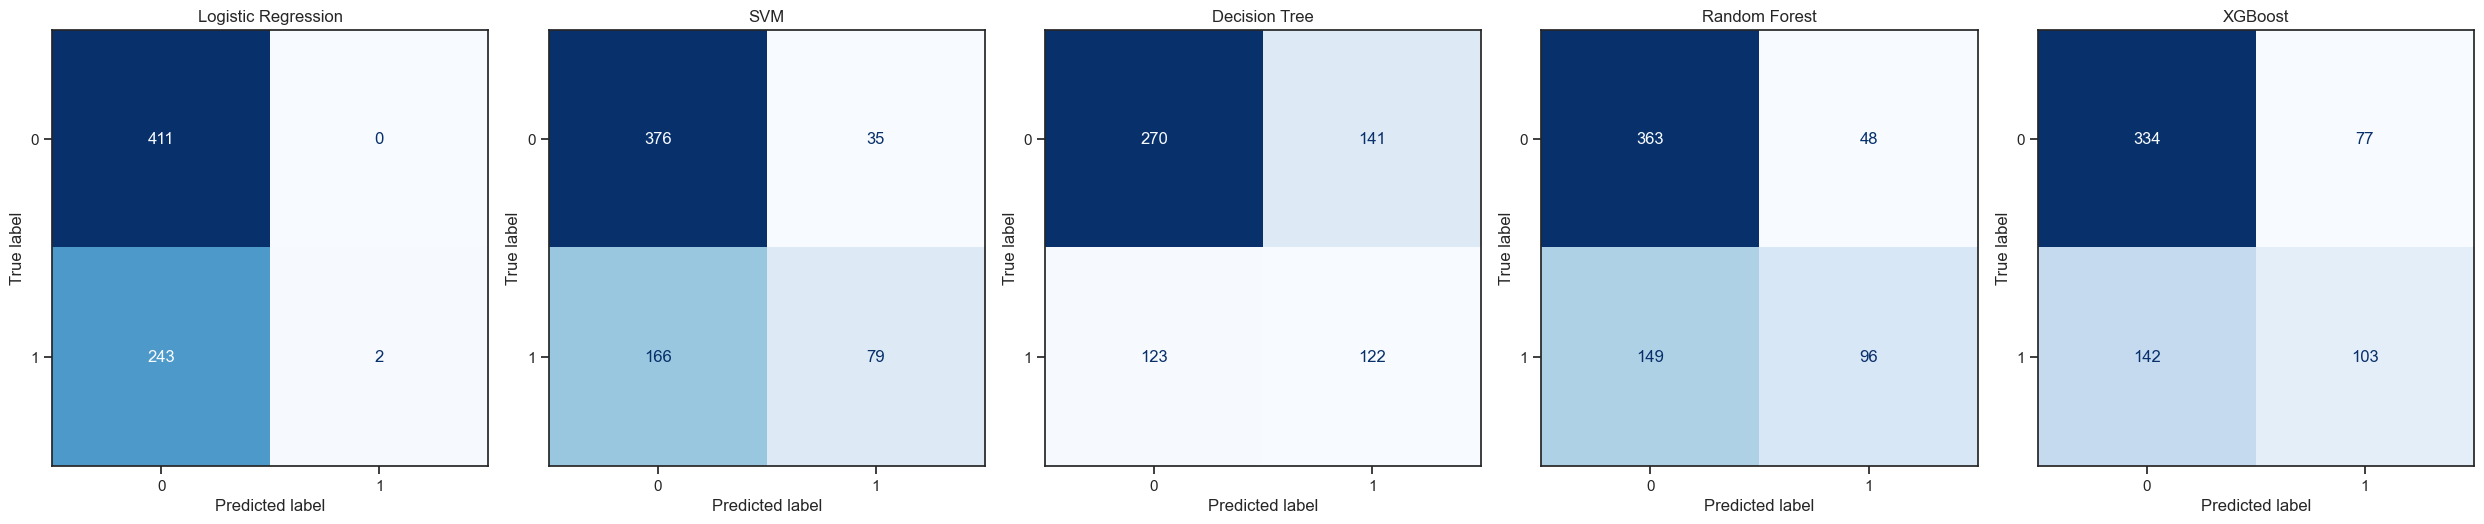

In [ ]:
# --- Построение матриц ошибок ---
fig, axes = plt.subplots(1, 5, figsize=(25, 5)) 

# Logistic Regression
cm = confusion_matrix(y_test, lr_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Logistic Regression')
axes[0].images[0].colorbar.remove() 

# SVM
cm = confusion_matrix(y_test, svm_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title('SVM')
axes[1].images[0].colorbar.remove()

# Decision Tree
cm = confusion_matrix(y_test, dt_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[2], cmap=plt.cm.Blues)
axes[2].set_title('Decision Tree')
axes[2].images[0].colorbar.remove()

# Random Forest
cm = confusion_matrix(y_test, rf_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[3], cmap=plt.cm.Blues)
axes[3].set_title('Random Forest')
axes[3].images[0].colorbar.remove()

# XGBoost
cm = confusion_matrix(y_test, xgb_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[4], cmap=plt.cm.Blues)
axes[4].set_title('XGBoost')
axes[4].images[0].colorbar.remove()

plt.tight_layout() 
plt.show()

#### ROC-кривая и ROC AUC

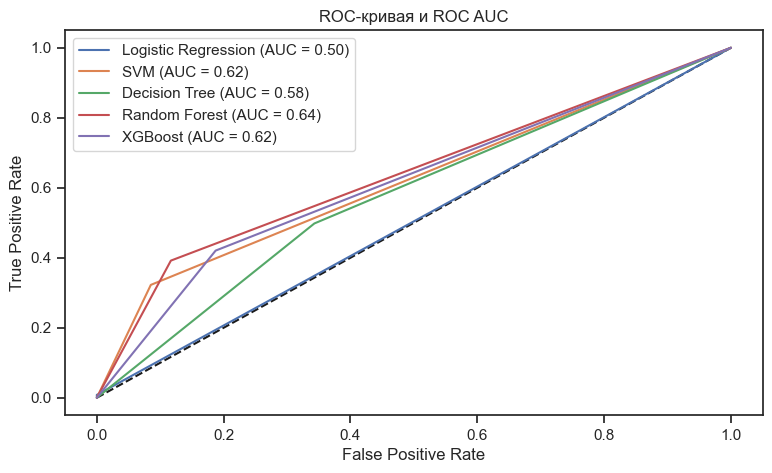

In [ ]:
# --- Расчет ROC-AUC и построение ROC-кривой ---
plt.figure(figsize=(9, 5))
plt.plot([0, 1], [0, 1], 'k--')

# Logistic Regression
fpr, tpr, thresholds = roc_curve(y_test, lr_y_pred)
auc = roc_auc_score(y_test, lr_y_pred)
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.2f})')

# SVM
fpr, tpr, thresholds = roc_curve(y_test, svm_y_pred)
auc = roc_auc_score(y_test, svm_y_pred)
plt.plot(fpr, tpr, label=f'SVM (AUC = {auc:.2f})')

# Decision Tree
fpr, tpr, thresholds = roc_curve(y_test, dt_y_pred)
auc = roc_auc_score(y_test, dt_y_pred)
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {auc:.2f})')

# Random Forest
fpr, tpr, thresholds = roc_curve(y_test, rf_y_pred)
auc = roc_auc_score(y_test, rf_y_pred)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc:.2f})')

# XGBoost
fpr, tpr, thresholds = roc_curve(y_test, xgb_y_pred)
auc = roc_auc_score(y_test, xgb_y_pred)
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.2f})')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая и ROC AUC')
plt.legend()
plt.show()

## Подбор гиперпараметров

In [167]:
from sklearn.model_selection import KFold

cv_kfold = KFold(n_splits=5, shuffle=True, random_state=42) 

# --- 1. Логистическая регрессия ---
lr_params = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100], 
    'solver': ['lbfgs', 'liblinear', 'saga']}
lr_grid = GridSearchCV(
    LogisticRegression(random_state=42, class_weight='balanced'),
    lr_params,
    cv=cv_kfold,
    scoring="f1",
)
lr_grid.fit(X_train, y_train)
lr_best_model = lr_grid.best_estimator_
tuned_lr_y_pred = lr_best_model.predict(X_test)
lr_best_params = lr_grid.best_params_

# --- 2. Метод опорных векторов (SVM) ---
svm_params = {
    "C": [0.1, 1, 10], 
    "kernel": ["linear", "rbf"]}
svm_grid = GridSearchCV(
    SVC(random_state=42, probability=True, class_weight='balanced'), 
    svm_params, 
    cv=3, 
    scoring="f1"
)
svm_grid.fit(X_train, y_train)
svm_best_model = svm_grid.best_estimator_
tuned_svm_y_pred = svm_best_model.predict(X_test)
svm_best_params = svm_grid.best_params_


# --- 3. Дерево решений ---
dt_params = {
    "max_depth": [3, 5, 7, None], 
    "min_samples_split": [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]}
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'), 
    dt_params, 
    cv=3, 
    scoring="f1"
)
dt_grid.fit(X_train, y_train)
dt_best_model = dt_grid.best_estimator_
tuned_dt_y_pred = dt_best_model.predict(X_test)
dt_best_params = dt_grid.best_params_

# --- 4. Случайный лес ---
rf_params = {
    "n_estimators": [50, 100, 200], 
    "max_depth": [5, 10, None]}
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'), 
    rf_params, 
    cv=3, 
    scoring="f1"
)
rf_grid.fit(X_train, y_train)
rf_best_model = rf_grid.best_estimator_
tuned_rf_y_pred = rf_best_model.predict(X_test)
rf_best_params = rf_grid.best_params_

# --- 5. Градиентный бустинг (XGBoost) ---
xgb_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
}
xgb_grid = GridSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric="logloss"),
    xgb_params,
    cv=3,
    scoring="f1",
)
xgb_grid.fit(X_train, y_train)
xgb_best_model = xgb_grid.best_estimator_
tuned_xgb_y_pred = xgb_best_model.predict(X_test)
xgb_best_params = xgb_grid.best_params_

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
# --- Расчет метрик и вывод результатов ---
model_names = [
    "Logistic Regression",
    "SVM",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
]
y_preds = [tuned_lr_y_pred, tuned_svm_y_pred, tuned_dt_y_pred, tuned_rf_y_pred, tuned_xgb_y_pred]
best_params = [
    lr_best_params,
    svm_best_params,
    dt_best_params,
    rf_best_params,
    xgb_best_params,
]  

model_metrics = []
for i, (name, y_pred) in enumerate(zip(model_names, y_preds)):
    accuracy = balanced_accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    model_metrics.append(
        [name, accuracy, balanced_accuracy, f1, best_params[i]]
    ) 

headers = [
    "Model",
    "Accuracy",
    "Balanced Accuracy",
    "F1 Score",
    "Best Parameters",
] 
table = tabulate(model_metrics, headers=headers, tablefmt="grid")

print(table)

+---------------------+------------+---------------------+------------+-----------------------------------------------------------------+
| Model               |   Accuracy |   Balanced Accuracy |   F1 Score | Best Parameters                                                 |
+=====================+============+=====================+============+=================================================================+
| Logistic Regression |   0.503198 |            0.503198 |   0.424242 | {'C': 0.001, 'solver': 'liblinear'}                             |
+---------------------+------------+---------------------+------------+-----------------------------------------------------------------+
| SVM                 |   0.639337 |            0.639337 |   0.555118 | {'C': 1, 'kernel': 'rbf'}                                       |
+---------------------+------------+---------------------+------------+-----------------------------------------------------------------+
| Decision Tree       |   0.526982

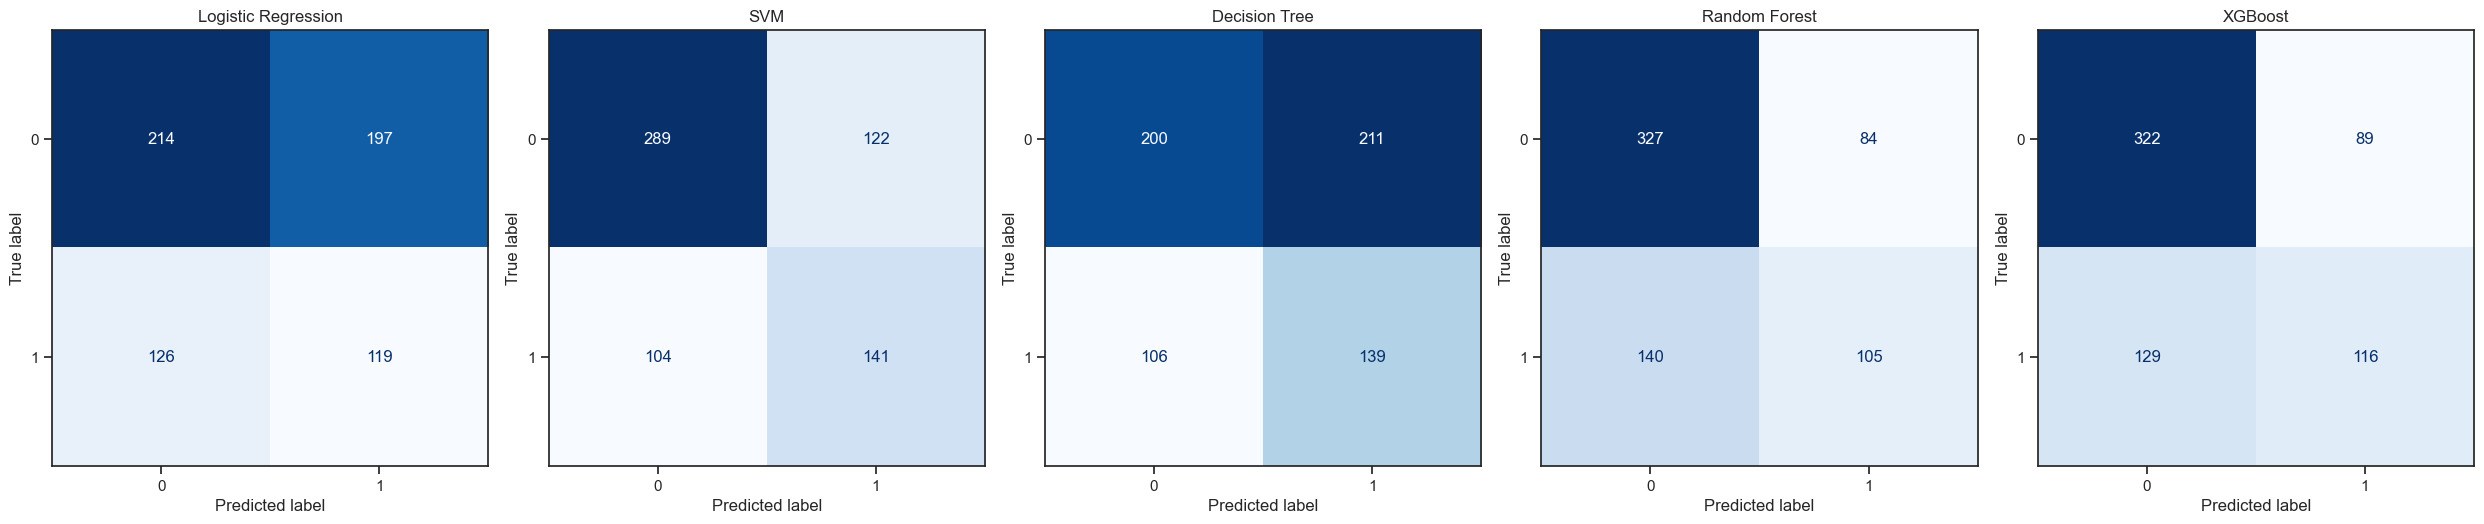

In [ ]:
# --- Построение матриц ошибок ---
fig, axes = plt.subplots(1, 5, figsize=(25, 5)) 

# Logistic Regression
cm = confusion_matrix(y_test, tuned_lr_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Logistic Regression')
axes[0].images[0].colorbar.remove() 

# SVM
cm = confusion_matrix(y_test, tuned_svm_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title('SVM')
axes[1].images[0].colorbar.remove()

# Decision Tree
cm = confusion_matrix(y_test, tuned_dt_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[2], cmap=plt.cm.Blues)
axes[2].set_title('Decision Tree')
axes[2].images[0].colorbar.remove()

# Random Forest
cm = confusion_matrix(y_test, tuned_rf_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[3], cmap=plt.cm.Blues)
axes[3].set_title('Random Forest')
axes[3].images[0].colorbar.remove()

# XGBoost
cm = confusion_matrix(y_test, tuned_xgb_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[4], cmap=plt.cm.Blues)
axes[4].set_title('XGBoost')
axes[4].images[0].colorbar.remove()

plt.tight_layout() 
plt.show()


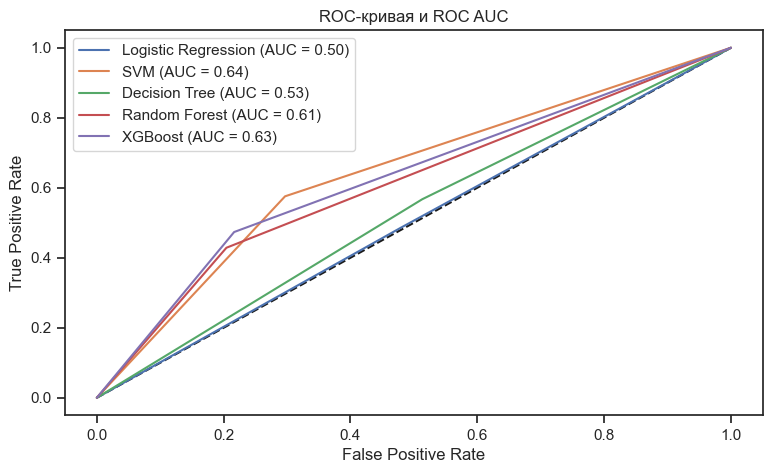

In [170]:
# --- Расчет ROC-AUC и построение ROC-кривой ---
plt.figure(figsize=(9, 5))
plt.plot([0, 1], [0, 1], 'k--') # Диагональ для сравнения

# Logistic Regression
fpr, tpr, thresholds = roc_curve(y_test, tuned_lr_y_pred)
auc = roc_auc_score(y_test, tuned_lr_y_pred)
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.2f})')

# SVM
fpr, tpr, thresholds = roc_curve(y_test, tuned_svm_y_pred)
auc = roc_auc_score(y_test, tuned_svm_y_pred)
plt.plot(fpr, tpr, label=f'SVM (AUC = {auc:.2f})')

# Decision Tree
fpr, tpr, thresholds = roc_curve(y_test, tuned_dt_y_pred)
auc = roc_auc_score(y_test, tuned_dt_y_pred)
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {auc:.2f})')

# Random Forest
fpr, tpr, thresholds = roc_curve(y_test, tuned_rf_y_pred)
auc = roc_auc_score(y_test, tuned_rf_y_pred)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc:.2f})')

# XGBoost
fpr, tpr, thresholds = roc_curve(y_test, tuned_xgb_y_pred)
auc = roc_auc_score(y_test, tuned_xgb_y_pred)
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.2f})')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая и ROC AUC')
plt.legend()
plt.show()

## Сравнение baseline и оптимального решения

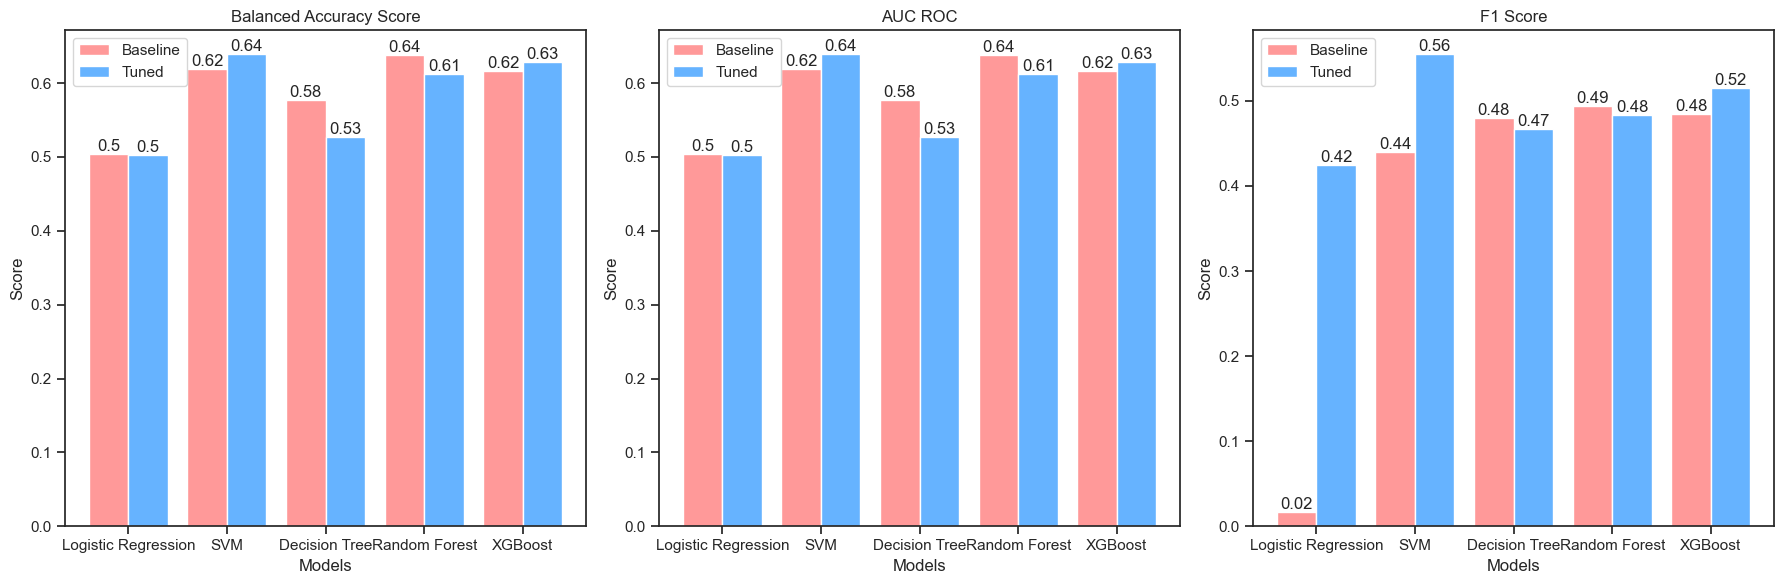

In [171]:
baseline_preds = [lr_y_pred, svm_y_pred, dt_y_pred, rf_y_pred, xgb_y_pred]
tuned_preds = [tuned_lr_y_pred, tuned_svm_y_pred, tuned_dt_y_pred, tuned_rf_y_pred, tuned_xgb_y_pred]

model_names = ['Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest', 'XGBoost']

baseline_balanced_acc = [balanced_accuracy_score(y_test, pred) for pred in baseline_preds]
baseline_auc = [roc_auc_score(y_test, pred) for pred in baseline_preds]
baseline_f1 = [f1_score(y_test, pred) for pred in baseline_preds]

tuned_balanced_acc = [balanced_accuracy_score(y_test, pred) for pred in tuned_preds]
tuned_auc = [roc_auc_score(y_test, pred) for pred in tuned_preds]
tuned_f1 = [f1_score(y_test, pred) for pred in tuned_preds] 

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ['Balanced Accuracy Score', 'AUC ROC', 'F1 Score']
metrics_baseline = [baseline_balanced_acc, baseline_auc, baseline_f1]
metrics_tuned = [tuned_balanced_acc, tuned_auc, tuned_f1]
colors = ['#ff9999','#66b3ff']

for i, (baseline_scores, tuned_scores, title) in enumerate(zip(metrics_baseline, metrics_tuned, titles)):
    x = np.arange(len(model_names)) 
    width = 0.4

    bars1 = axes[i].bar(x - width/2, baseline_scores, width, label='Baseline', color=colors[0])
    bars2 = axes[i].bar(x + width/2, tuned_scores, width, label='Tuned', color=colors[1])

    for bars in (bars1, bars2):
        for bar in bars:
            yval = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2),
                         ha='center', va='bottom')

    axes[i].set_title(title)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(model_names)
    axes[i].set_xlabel('Models')
    axes[i].set_ylabel('Score')
    axes[i].legend()

plt.tight_layout()
plt.show()


💡 Лучшие результаты показала модель SVM (balanced accuracy = 0.64, AUC ROC = 0.64, F1-мера = 0.56).  
Строго говоря, ни одна из моделей не может быть использована для определения пригодности воды для питья, так как качество бинарной классификации достаточно низкое, а ошибка может иметь критические последствия.